### TimeSeries
+ FinanceDataReader 사용

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import FinanceDataReader as fdr

#### 0. 데이터 확인

In [16]:
#삼성전자
plt.rc("font", family="Malgun Gothic")
samsung = fdr.DataReader("005930")
print(samsung)

             Open   High    Low  Close    Volume    Change
Date                                                      
1998-12-24   1522   1549   1488   1532    941106       NaN
1998-12-28   1570   1570   1503   1546    537290  0.009138
1999-01-04   1776   1776   1624   1693    666160  0.095084
1999-01-05   1692   1712   1649   1673    643209 -0.011813
1999-01-06   1702   1720   1651   1718    645110  0.026898
...           ...    ...    ...    ...       ...       ...
2023-04-07  63800  65200  63800  65000  27476120  0.043339
2023-04-10  64800  66300  64700  65700  18777166  0.010769
2023-04-11  66200  66200  65400  65900  16323183  0.003044
2023-04-12  65800  66200  65300  66000  15021313  0.001517
2023-04-13  65600  66100  65400  65500  10530212 -0.007576

[6000 rows x 6 columns]


In [21]:
def show_ts(df): 
    plt.figure(figsize=(13,5))
    sns.lineplot(x=df.index, y="Close", data=df)
    plt.xlabel("시간")
    plt.ylabel("종가")
    plt.show()

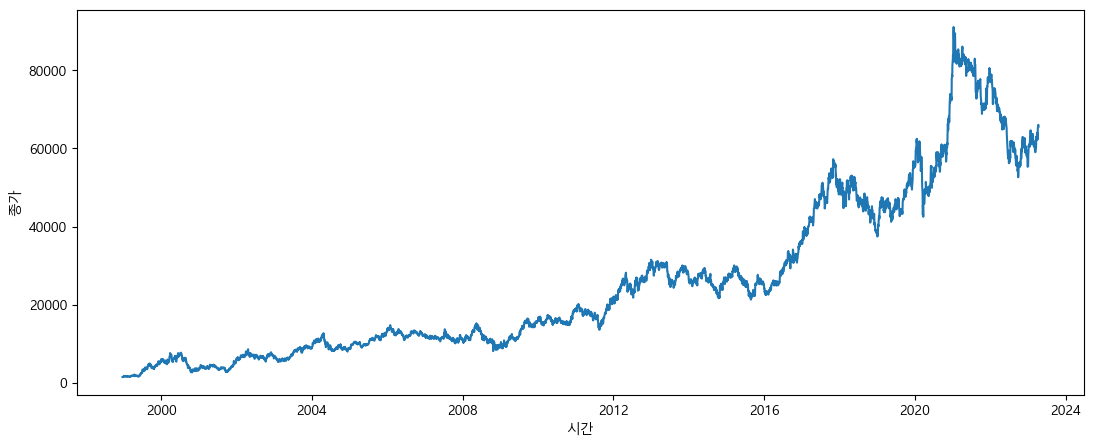

In [23]:
show_ts(samsung)

In [27]:
# 매직넘버
time_steps = [["1990", "2000"],
              ["2000", "2010"],
              ["2010", "2015"],
              ["2015", "2020"],
              ["2020", "2022"]]

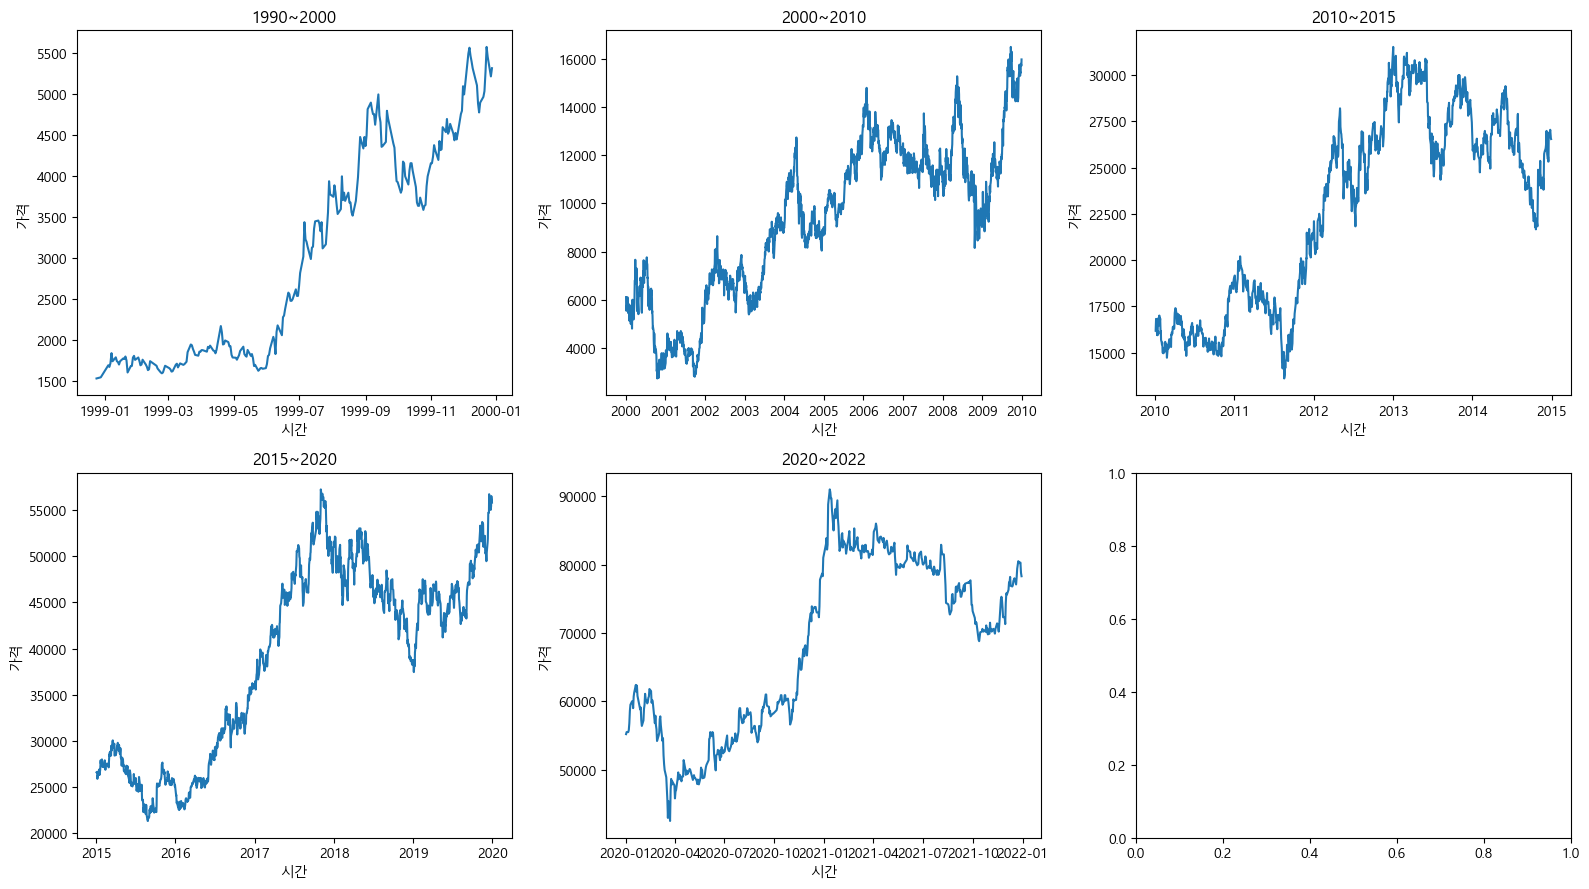

In [28]:
fig, axes = plt.subplots(2,3)
fig.set_size_inches(16,9)
for i in range(5):
    ax = axes[i//3, i%3]
    df = samsung.loc[(samsung.index > time_steps[i][0]) & (samsung.index < time_steps[i][1])]
    sns.lineplot(x=df.index, y=df["Close"], ax=ax) #ax 데이터 그릴 축을 반드시 정해줘야함
    ax.set_title(f"{time_steps[i][0]}~{time_steps[i][1]}")
    ax.set_xlabel("시간")
    ax.set_ylabel("가격")
plt.tight_layout()
plt.show()

#### 1. prophet 사용하기
+ y컬럼(예측값), ds컬럼(시간)이 존재해야 함

In [30]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [32]:
# 데이터 가공
# 시계열은 N/A값 삭제하지 않음!! (fillNA)
stock = fdr.DataReader("005930", "2022")
stock["y"] = stock["Close"]
stock["ds"] = stock.index
stock.head()

,Open,High,Low,Close,Volume,Change,y,ds
Date,,,,,,,,
2022-01-03,79400,79800,78200,78600,13502112,0.003831,78600,2022-01-03
2022-01-04,78800,79200,78300,78700,12427416,0.001272,78700,2022-01-04
2022-01-05,78800,79000,76400,77400,25470640,-0.016518,77400,2022-01-05
2022-01-06,76700,77600,76600,76900,12931954,-0.006460,76900,2022-01-06
2022-01-07,78100,78400,77400,78300,15163757,0.018205,78300,2022-01-07


In [33]:
# Raw Data Fitting
m = Prophet()
m.fit(stock)

16:21:53 - cmdstanpy - INFO - Chain [1] start processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
# 기간 설정
# 예측을 원하는 기간(Day)을 정해서 date time_stamps를 만듦
# 보통은 길어야 7일 예측 / working day 여부도 확인
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
342,2023-05-09
343,2023-05-10
344,2023-05-11
345,2023-05-12
346,2023-05-13


In [40]:
#yhat : 예측값
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
342,2023-05-09,64072.079937,61656.283785,66453.953702,63918.277406,64200.775746,-170.170033,-170.170033,-170.170033,-170.170033,-170.170033,-170.170033,0.0,0.0,0.0,63901.909904
343,2023-05-10,64100.308690,61637.878523,66325.306016,63935.625093,64236.099503,-167.939246,-167.939246,-167.939246,-167.939246,-167.939246,-167.939246,0.0,0.0,0.0,63932.369444
344,2023-05-11,64128.537443,61619.183205,66185.177125,63949.644981,64274.927644,-217.837661,-217.837661,-217.837661,-217.837661,-217.837661,-217.837661,0.0,0.0,0.0,63910.699782
345,2023-05-12,64156.766196,61824.622659,66466.752478,63963.405283,64309.337671,-19.527359,-19.527359,-19.527359,-19.527359,-19.527359,-19.527359,0.0,0.0,0.0,64137.238837
346,2023-05-13,64184.994949,62074.559590,66921.828336,63979.638030,64345.663181,349.894022,349.894022,349.894022,349.894022,349.894022,349.894022,0.0,0.0,0.0,64534.888971


In [43]:
# 필요한 값만 가져오기
# 예측결과 데이터 확인해보기
# 이왕이면 전체데이터 확인
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].iloc[-40:-20]

,ds,yhat,yhat_lower,yhat_upper
307,2023-03-31,62951.631210,60762.009682,65192.447873
308,2023-04-03,62931.531191,60391.380849,65369.393095
309,2023-04-04,62913.903549,60427.361449,65414.740997
310,2023-04-05,62944.363088,60570.643474,65359.874650
311,2023-04-06,62922.693426,60502.399791,65260.871684
312,2023-04-07,63149.232481,60725.785673,65504.479458
313,2023-04-10,63129.132462,60717.591512,65538.588050
314,2023-04-11,63111.504820,60820.354185,65490.713868
315,2023-04-12,63141.964359,60843.258900,65606.068904
316,2023-04-13,63120.294698,60759.722184,65428.320481


In [50]:
# 이왕이면 plotly 사용
# m.plot(forecast)
fig = plot_plotly(m, forecast)
fig

In [47]:
# 세부 컴포넌트 이용해서 데이터 확인
plot_components_plotly(m, forecast)

+ 변경점 확인

In [48]:
from prophet.plot import add_changepoints_to_plot

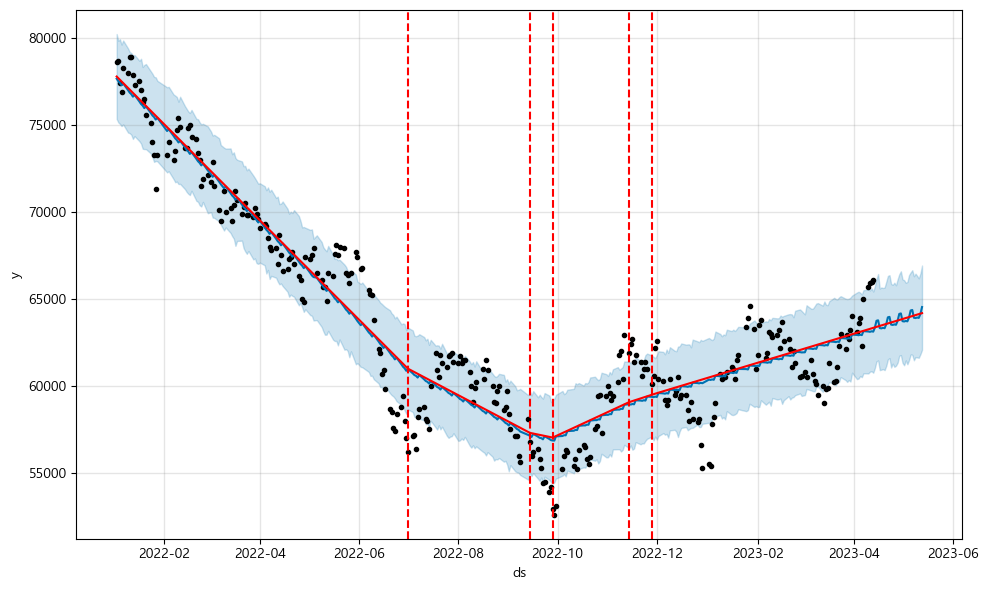

In [49]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

17:14:48 - cmdstanpy - INFO - Chain [1] start processing
17:14:48 - cmdstanpy - INFO - Chain [1] done processing


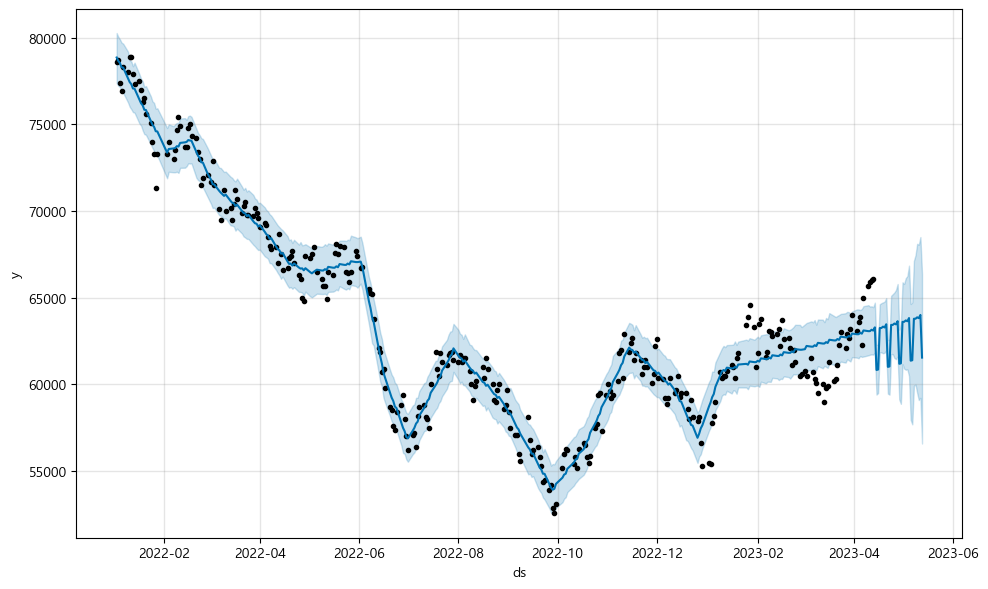

In [55]:
# 오버피팅 되었다고 생각이 들 경우 유연성 조정
# 유연성 : 계수가 낮으면 과소적합, 높으면 과대적합 => 조정은 내가 한다...
m = Prophet(changepoint_prior_scale=0.8)
forecast = m.fit(stock).predict(future)
fig = m.plot(forecast)